## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
   
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True) #將save_best_only設成False

In [8]:

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

#儲存訓練結果及權重
model.save("final_model.h5")
model.save_weights("model_weights.h5")

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]


W0724 02:47:03.326213 139673958016896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 02:47:03.340554 139673958016896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 02:47:03.343600 139673958016896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 02:47:03.419505 139673958016896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 02:47:03.727859 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

In [0]:
#本次訓練最終結果, 但不一定是此次訓練中最佳的epoch
pred_final = model.predict(x_test)

# Load back; 設save_best_only=True,執行中存最佳版本,所以會比本次訓練最終結果好
model = keras.models.load_model("./tmp.h5")
pred_loadback = model.predict(x_test)

In [10]:
from sklearn.metrics import accuracy_score

# When you pass the axis parameter to the argmax function, 
# the indices returned will be based on this axis. Your results will lose this specific axes, but keep the others
# Negative numbers represent the inverse order:
#   data shape: (19,19,5,80), Axis -1 = 80 elements, Axis -2 = 5 elements...
final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1)) #argmax(axis=-1)?? 因為結果是10維機率,用argmax取出最大值
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.486
Accuracy of best weights: 0.490


In [11]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1)) 
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("./model_weights.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.087
Accuracy of best weights: 0.486


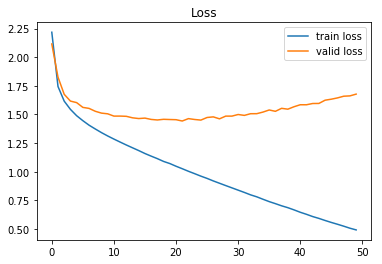

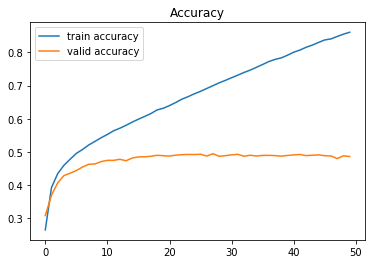

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
#plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
#plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [23]:
fin = accuracy_score(y_true=y_test.argmax(axis=-1)[:3], y_pred=pred_final.argmax(axis=-1)[:3]) #argmax(axis=-1)?? 由後面往前取最大
loa = accuracy_score(y_true=y_test.argmax(axis=0), y_pred=pred_loadback.argmax(axis=0))

print("Accuracy of final weights: %.3f" % fin)
print("Accuracy of best weights: %.3f" % loa)

Accuracy of final weights: 0.667
Accuracy of best weights: 0.000


In [21]:
pred_final[:3] #10個output可能機率

array([[8.75680242e-04, 7.16062589e-03, 5.93906874e-03, 7.06397653e-01,
        8.62587243e-04, 2.70491123e-01, 6.57926267e-03, 2.51056161e-04,
        1.36249699e-03, 8.04446536e-05],
       [1.77774504e-02, 2.67879874e-01, 1.03298214e-03, 3.99617990e-03,
        7.94946402e-03, 3.63665191e-03, 4.05093539e-04, 1.18279153e-04,
        5.35068631e-01, 1.62135392e-01],
       [2.21945018e-01, 1.32790357e-01, 3.11708474e-03, 6.06901105e-03,
        1.11471033e-02, 5.37974352e-04, 1.09028464e-04, 6.74305891e-04,
        2.69956231e-01, 3.53653878e-01]], dtype=float32)

In [19]:
y_test[:3]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [29]:
y_true=y_test.argmax(axis=-1)[:10]
y_pred=pred_final.argmax(axis=-1)[:10]
y_true, y_pred

(array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1]), array([3, 8, 9, 4, 4, 6, 3, 6, 5, 8]))

In [30]:
y_true=y_test.argmax(axis=1)[:10]
y_pred=pred_final.argmax(axis=1)[:10]
y_true, y_pred

(array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1]), array([3, 8, 9, 4, 4, 6, 3, 6, 5, 8]))